<a href="https://colab.research.google.com/github/al0nkr/car-recommender-system/blob/main/car_recommender_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Accessing data from Google Drive
> Mounting google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [20]:
import torch
from pathlib import Path
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
from torchvision.transforms import ToTensor
import random
import shutil
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

### Setting up path variables

In [21]:
data_path = Path('/content/drive/MyDrive/Datasets/Stanford_cars')
train_dir = data_path / 'cars_train/cars_train'
test_dir = data_path / 'cars_test/cars_test'
anno = data_path / 'cars_annos.mat'
train_anno = data_path / 'train_perfect_preds.txt'

train_dir , test_dir , anno , train_anno

(PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/cars_test'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/cars_annos.mat'),
 PosixPath('/content/drive/MyDrive/Datasets/Stanford_cars/train_perfect_preds.txt'))

### Data path exploration
> prefer skipping this step to reduce time

In [ ]:
# Exploring data directories
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(data_path)

There are 2 directories and 1 images in '/content/drive/MyDrive/Datasets/Stanford_cars'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train'.
There are 0 directories and 8144 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test'.
There are 0 directories and 8041 images in '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/cars_test'.


### Reducing Train and Test datasets

In [22]:
#training subset folder
train_file_list = os.listdir(train_dir)
sub_size = int(len(train_file_list) * 0.1)
train_sub_files = random.sample(train_file_list, sub_size)

train_sub_path = '/content/drive/MyDrive/Datasets/Stanford_cars/cars_train/train_subset'
os.makedirs(train_sub_path, exist_ok=True)

#test subset folder
test_file_list = os.listdir(test_dir)
sub_size = int(len(test_file_list) * 0.05)
test_sub_files = random.sample(test_file_list, sub_size)

test_sub_path = '/content/drive/MyDrive/Datasets/Stanford_cars/cars_test/test_subset'
os.makedirs(test_sub_path, exist_ok=True)

In [ ]:
#copying subset of train files
if len(os.listdir(train_sub_path)) < 2: #here we check if directory has any files besides the cars_train folder
  for filename in tqdm(train_sub_files,desc="Copying Train Subset Files"):
      src_path = os.path.join(train_dir, filename)
      dst_path = os.path.join(train_sub_path, filename)
      shutil.copyfile(src_path, dst_path)
else:
  print('Files already copied to directory')


Files already copied to directory


In [ ]:
#copying subset of test files
if len(os.listdir(test_sub_path)) < 2: # same as earlier , check if folder has anything other than cars_test
  for filename in tqdm(test_sub_files,desc="Copying Test Subset Files"):
      src_path = os.path.join(test_dir, filename)
      dst_path = os.path.join(test_sub_path, filename)
      shutil.copyfile(src_path, dst_path)
else:
  print('Files already copied to directory')

Files already copied to directory


### Transforming images to tensors

In [ ]:
#setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
#universal datatransform used for converting images to tensors with standardized mean
data_transform = transforms.Compose([
                transforms.Resize(size = (224,224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


### Generating Labels

In [23]:
#generating a datafram to access all image labels and their respective locations
cars_anno = loadmat(anno)
x = cars_anno['class_names']

anno_df = pd.DataFrame(x)
anno_df.head()

train_labels = pd.read_csv(train_anno,header = None)
df = pd.DataFrame(train_labels)
df["image"] = train_labels.index
img_list = []
for i in df.image:
  img_list.append(str(i+1).zfill(5) + ".jpg")

img_list
df["image"] = img_list

df.rename(columns={0:"labels"}, inplace=True)
train_labels

,labels,image
0,14,00001.jpg
1,3,00002.jpg
2,91,00003.jpg
3,134,00004.jpg
4,106,00005.jpg
...,...,...
8139,78,08140.jpg
8140,196,08141.jpg
8141,163,08142.jpg
8142,112,08143.jpg


### ResNet from scratch

>This ResNet-18 implementation, while simplified, retains the core components and structure of the original ResNet-18 architecture.

>The `BasicBlock` consists of two 3x3 convolutional layers with batch normalization and ReLU activation, followed by an element-wise addition of the input to the output (residual connection).

>The `ResNet18` class represents the ResNet-18 architecture used to reduce the spatial dimensions further. [*To expand its layers, we can follow the original paper's descriptions and change the stride factors according to our needs*]

>`_make_layer` method creates a sequence of BasicBlock layers. It takes the number of output channels, the number of blocks to create, and the stride as input arguments. It creates a BasicBlock with the given parameters and appends it to the sequence.

> The `forward` method implements the forward pass of the network.

> The implementation uses pre-trained weights for ResNet-18 provided by the torchvision library. It loads the weights into the ResNet18 model to use them during inference.


In [47]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != self.expansion * out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(self.expansion * out_channels)
      )

  def forward(self, x):
    residual = x

    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))

    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet18(nn.Module):
  def __init__(self, num_classes=1000):
    super(ResNet18, self).__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self._make_layer(64, 2, stride=1)
    self.layer2 = self._make_layer(128, 2, stride=2)
    self.layer3 = self._make_layer(256, 2, stride=2)
    self.layer4 = self._make_layer(512, 2, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, out_channels, blocks, stride):
    layers = []
    layers.append(BasicBlock(self.in_channels, out_channels, stride))
    self.in_channels = out_channels * BasicBlock.expansion
    for _ in range(1, blocks):
      layers.append(BasicBlock(self.in_channels, out_channels))
      self.in_channels = out_channels * BasicBlock.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

myresnet = ResNet18()
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/resnet18-5c106cde.pth")

# Fix the state_dict keys to match the custom ResNet-18 model
fixed_state_dict = {}
for key, value in state_dict.items():
    fixed_key = key.replace("downsample.", "shortcut.")
    fixed_state_dict[fixed_key] = value

myresnet.load_state_dict(fixed_state_dict) # Load the fixed state_dict into the custom ResNet-18 model

myresnet.fc = nn.Identity() #removes fully connected layer to give an output of [1x512] as image features

### Setting up Image Folder

`ImageFolderDataset` class reads image files from a folder, applies image transformations, and creates a DataLoader to efficiently load images in batches.
The `dataloader` is used for iterating through the dataset in batches during training. The dataset loads and transforms images on-the-fly as they are accessed.

In [48]:
class ImageFolderDataset(Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    self.file_paths = sorted([os.path.join(root, f) for f in os.listdir(root) if self._is_image_file(f)])

  def __getitem__(self, index):
    file_path = self.file_paths[index]
    image = Image.open(file_path).convert('RGB')

    if self.transform is not None:
      image = self.transform(image)

    return image,file_path

  def __len__(self):
    return len(self.file_paths)

  def _is_image_file(self, file_name):
    return file_name.lower().endswith(('.jpg','.jpeg'))

# Define the path to your image folder
image_folder_path = train_sub_path #train_dir


# Create the ImageFolderDataset
dataset = ImageFolderDataset(image_folder_path, transform=data_transform)

# Create the DataLoader
batch_size = 32  # Define your desired batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for images in tqdm(dataloader):
    pass


100%|██████████| 26/26 [00:08<00:00,  3.07it/s]


### Generating Recommendations

The `ImageFeatureExtractor` class is the heart of the program , designed to extract features from images using a pre-trained ResNet model and find similar images based on cosine similarity.

`extract_features` method takes an image tensor, passes it through the model, and returns the flattened feature representation of the image.

`compute_cosine_similarity` method calculates the cosine similarity between a query feature and a list of dataset features.

`find_similar_images` method takes a query image, loads the dataset images from the given DataLoader, and computes cosine similarities between the query image's features and the dataset images' features. It returns a dictionary with file paths of similar images as keys and their similarity scores as values.


In [49]:
class ImageFeatureExtractor:
  def __init__(self):
    self.model = myresnet
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)
    self.model.eval()

  def extract_features(self, image):
    with torch.no_grad():
      image = image.to(self.device)
      features = self.model(image)
      features = torch.flatten(features, start_dim=1)
    return features.cpu()  # Move tensor to CPU

  def compute_cosine_similarity(self, query_features, dataset_features):
    query_features = query_features.view(1, -1)
    dataset_features = dataset_features.view(dataset_features.size(0), -1)

    # Normalize the features to have unit length
    query_features = F.normalize(query_features, dim=1)
    dataset_features = F.normalize(dataset_features, dim=1)

    similarities = cosine_similarity(query_features, dataset_features)
    return similarities.squeeze().tolist()

  def find_similar_images(self, query_image, dataset_loader, k=10):
    query_tensor = ToTensor()(query_image)
    query_tensor = query_tensor.unsqueeze(0)

    query_features = self.extract_features(query_tensor)
    dataset_features = []
    dataset_file_paths = []  # Store the file paths here

    with torch.no_grad():
      for images, file_paths in dataset_loader:
        images = images.to(self.device)
        features = self.model(images)
        features = torch.flatten(features, start_dim=1)
        dataset_features.append(features.cpu())
        dataset_file_paths.extend(file_paths)  # Store the file paths from the dataset_loader

    dataset_features = torch.cat(dataset_features, dim=0).cpu()

    similarities = self.compute_cosine_similarity(query_features, dataset_features)
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:k]

    score = [similarities[i] for i in sorted_indices]
    similar_image_paths = [dataset_file_paths[i] for i in sorted_indices]  # Use the stored file paths

    similar_img_score_dict = {key: value for key, value in zip(similar_image_paths, score)}
    return similar_img_score_dict

### Driver Code

Enter Index of Image : 898
Selected Image path: /content/drive/MyDrive/Datasets/Stanford_cars/cars_train/cars_train/08085.jpg
Image height: 477
Image width: 717


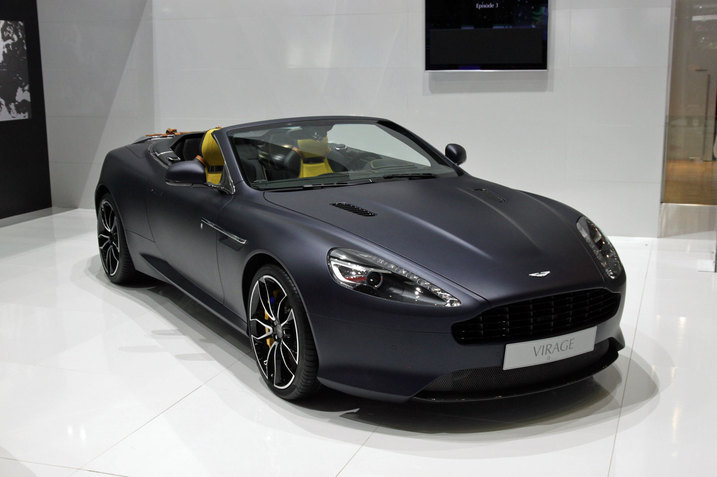

In [50]:
#Select Image index of images
image_path_list = list(data_path.glob("*/*/*.jpg"))
inp_index = int(input("Enter Index of Image : "))
selected_image = image_path_list[inp_index]
img = Image.open(selected_image)

print(f"Selected Image path: {selected_image}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

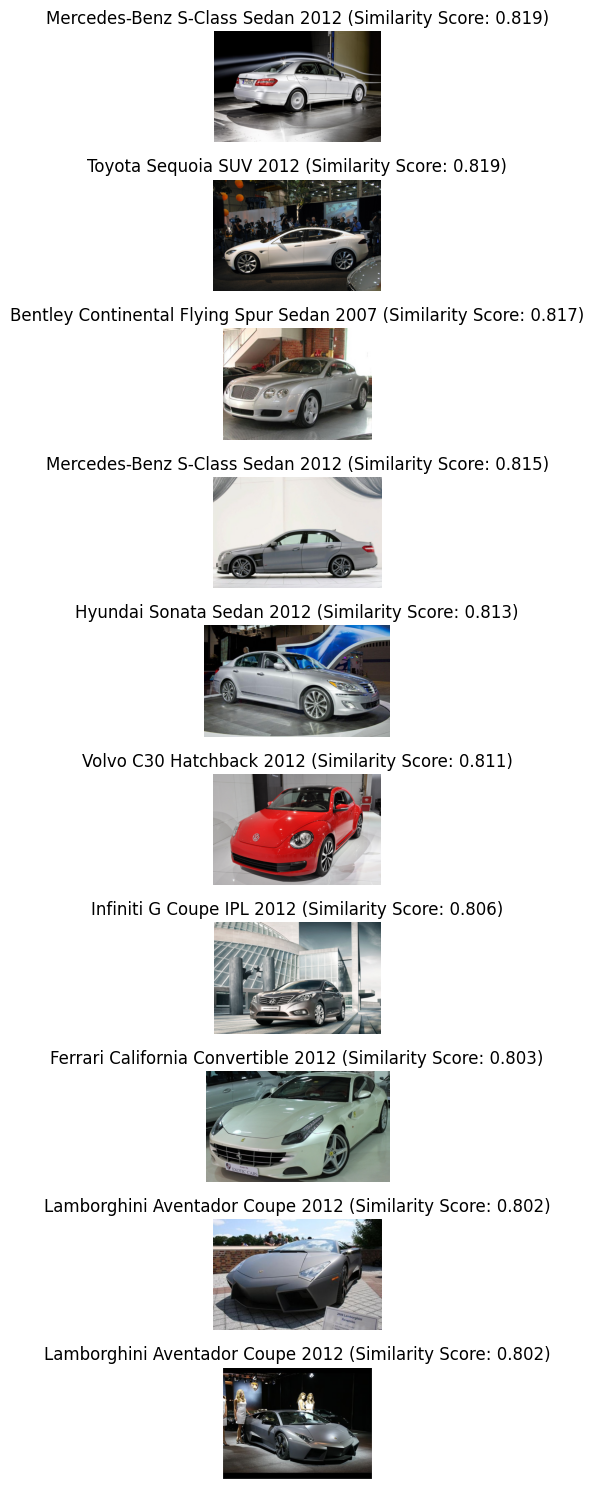

In [51]:
def pathGen(inp_path):
  op_indices = []
  for i in inp_path:
    op_indices.append(i[70:])
  return op_indices

def out_labels_gen(locs):
  out_labels = []
  for i in locs:
    s = str(anno_df[train_labels.loc[train_labels['image'] == i]['labels'].values[0]])
    start_pos = s.find('[')
    end_pos = s.find(']')
    val = s[start_pos + 1:end_pos]
    out_labels.append(val)

  return out_labels

def plot_imgs(image_paths, labels, scores, n=len(similar_images), seed=None):
  fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(7, 15))
  for i, path in enumerate(image_paths):
    with Image.open(path) as img:
      axs[i].imshow(img)
      axs[i].set_title(f"{labels[i]} (Similarity Score: {scores[i]:.3f})")
      axs[i].axis('off')
  plt.tight_layout()
  plt.show()

extractor = ImageFeatureExtractor()
similar_images = extractor.find_similar_images(img, dataloader)

out_img_idx = pathGen(list(similar_images.keys()))
out_labels = out_labels_gen(out_img_idx)
plot_imgs(list(similar_images.keys()),out_labels,list(similar_images.values()))
